## Generate Context tiles

This notebook shows how to generate context tiles for products like GFW and GFW Climate, via example:

### GFW Climate Biomass 

[GFW climate](http://climate.globalforestwatch.org/map/3/-28.56/79.56/ALL/dark/biomass_loss?begin=2001-11-10&end=2015-01-01&threshold=30) shows Carbon emissions from biomass loss (t CO2/ha).

![](./pics/gfw_biomass.png)

These data enable the user to select a tree cover canopy threshold of interest, and show biomass loss over time, enabling the user to select the time range of interest. 

The data come from webmap tiles.

For example, an old versions of these data produced by Google in 2014 are hosted at:

http://storage.googleapis.com/earthenginepartners-wri/whrc-hansen-carbon-{threshold}-{z}{/x}{/y}.png

These tiles are decoded by clientside javascript code [here](https://github.com/Vizzuality/gfw-climate/blob/develop/app/assets/javascripts/map/views/layers/BiomassLossLayer.js), and converted into a visulization of biomass loss.

If we zoom into some disctinct areas and examine the contents of the tile we will be able to understand more how these data are put together, and how to replicate them.

We will look at two informative areas, one in Jamaica, which shows 3 clear patches of carbon loss imposed over a small iland area, easy to identify:

<img src="./pics/Jamaica.png" width="600" height="600" />

And another which shows the data cutoff and a distinct error in the previously processed data over the Floridian peninsula:

<img src="./pics/florida.png" width="600" height="600" />

In [1]:
import requests
import math
import maya
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def deg2num(lat_deg, lon_deg, zoom):
    """Based on a zoom and lat long, get tile numbers"""
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)

deg2num(17.73, -77.18, 9) # position of Jamaica 

deg2num(30.12, -83.25, 7) # position north of Florida anomaly

(34, 52)

In [7]:
#tile_url = 'http://storage.googleapis.com/earthenginepartners-wri/whrc-hansen-carbon-30-9/146/230.png'
#tile_url = 'http://storage.googleapis.com/earthenginepartners-wri/whrc-hansen-carbon-30-7/34/52.png'

#tile_url = "https://storage.googleapis.com/gfw_clim/bentest/4/14/8.png"
#tile_url = "https://storage.googleapis.com/gfw-climate-tiles/biomassloss/v2.0/tc10/7/34/52.png"
tile_url = "https://storage.googleapis.com/gfw-climate-tiles/biomassloss/v2.0/tc10/7/100/61.png"
im_arrays = misc.imread(requests.get(tile_url, stream=True).raw, mode='RGBA')

BAND 0  R: max=16 min=0


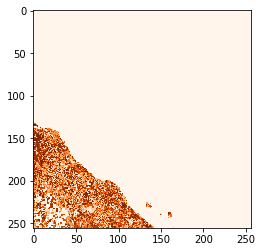

BAND 1  G: max=95 min=0


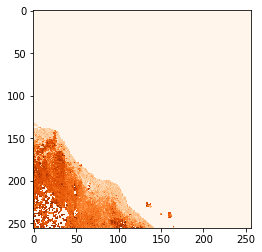

BAND 2  B: max=93 min=0


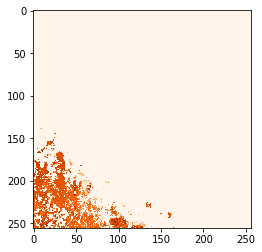

BAND 3  A: max=251 min=0


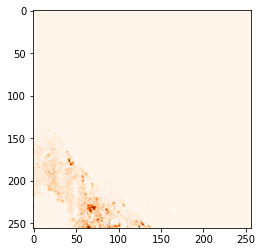

In [8]:
for n, band in enumerate(["R","G","B","A"]):
    print(f"BAND {n}  {band}: max={im_arrays[:,:,n].max()} min={im_arrays[:,:,n].min()}")
    plt.imshow(im_arrays[:,:,n], cmap='Oranges')
    plt.show()

* Red channel (band 0): encodes integer year - 2000 (i.e. years since 2000) of tree cover loss for trees >= a specified canopy threshold. With 0 values indicating points where no loss occured.

* Green channel (band 1): Biomass masked by year (and also uncertainty to constrain to tropics), scaled with unitScale(0, 450) and converted to 255

* Blue channel (band 2): Biomass (t/ha) scaled with unitScale(0, 450) and converted to 255. This should be unpacked on the front-end using ((value/917)*255)

* Alpha Channel (band 3): Uncertainty (t/ha) scaled to 255 using the formulae from the E.E. dataset 'users/davethau/whrc_carbon_test/uncertainty' with clamp(0,100) scaled to 255.


Note, in relation to the front-end code, the alpha channel of the decoded png data is not being used. I.e. the alpha channel of the above dataset is not currently being used by the front-end for anything.

Note: By checking the Florida anomaly its possible to verify that everwhere has been masked by the uncertainty data.


### A look at a histogram of the alpha channel

Looks like the clamp() function has been used on the uncertainty data.


In [ ]:
plt.hist(im_arrays[:,:,3].flatten(), bins=50)
plt.ylim(0,1000)

## Recreate the dataset

Using updated WHRC biomass data and updated Hansen tree cover data, we now need to re-create the Tau dataset.

1. First, we need to recreate the dataset images in the four bands.
2. Then we need to set the resolution of the layers, iterating through z-levels, downscaling with MODE
3. At each tree-cover threshold and z-level we need to write out the datasets as a tiles.

### Testing

The first stage will be visually testing these data as I create them using Folium:

In [ ]:
import os
import ee
import json
import folium
ee.Initialize()

In [ ]:
ee.data.setAssetAcl?

In [ ]:
ee.data.

In [ ]:
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))


def embed_map(map, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    map.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))


def tile_url(image, viz_params=None):
    """Create a target url for tiles for an image.
    e.g.
    im = ee.Image("LE7_TOA_1YEAR/" + year).select("B3","B2","B1")
    viz = {'opacity': 1, 'gain':3.5, 'bias':4, 'gamma':1.5}
    url = tile_url(image=im),viz_params=viz)
    """
    if viz_params:
        d = image.getMapId(viz_params)
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    url = (base_url + '/map/' + d['mapid'] + '/{z}/{x}/{y}?token=' + d['token'])
    return url

In [ ]:
# Biomass uncertainty data (which also serves as a PanTropical mask)
uncertainty = ee.Image('users/davethau/whrc_carbon_test/uncertainty')

def get_biomass(uncertainty=uncertainty):
    """ Create Woods Hole RC Biomass data image, scaled by x/917 * 255
        and converted to byte type.
    """
    neotropic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Neotropic')
    africa = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Africa')
    australia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Australia')
    tropasia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Tropical_Asia')
    palearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Palearctic')
    nearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Nearctic')
    # Combine the individual areas into a single collection
    ic = ee.ImageCollection([africa,australia, nearctic,
                                 neotropic, palearctic, tropasia])
    im = ic.max() # Now we have single image, but with discontinuties
    hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')
    datamask = hansenImage.select('datamask')
    mask = datamask.eq(1)
    land = mask # Make a land image out of the mask
    landmask = im.mask(land) # Mask land with itself to mask all the zeros (non-land)
    # make another collection from the landmask and the full coverage image
    ic_with_mask = ee.ImageCollection([landmask, im])
    # Finally convert that into a fully contingous image, with 0s where no data over land
    # and mask those data by uncertainty (as the original data were).
    biomass = ic_with_mask.max()
    biomass = biomass.mask(uncertainty).divide(917).multiply(255).byte()
    return biomass


def get_loss_year(threshold, uncertainty=uncertainty):
    """lossyear = get_loss_year(30) # get loss by year for canopy threshold of >30%
    This function expects that the uncertainty image has already been added to the namespace.
    """
    treeThresh = 30         # <--- Tree Thresholding set here (make this a function call in the future)
    raw_hansen = ee.Image("UMD/hansen/global_forest_change_2016_v1_4") # Up-to-date Hansen data
    tree_threshold_mask = raw_hansen.select('treecover2000').gte(threshold) 
    lossyear_for_threshold = raw_hansen.select('lossyear').mask(tree_threshold_mask)
    loss_by_year = lossyear_for_threshold.mask(lossyear_for_threshold).mask(uncertainty)
    loss_by_year = loss_by_year.mask(loss_by_year)    
    return loss_by_year

In [ ]:
biomass = get_biomass()
loss_by_year = get_loss_year(30)

In [ ]:
geom = ee.Feature(ee.Geometry.Polygon(
        [[[-122.6953125, 31.95216223802497],
          [-71.015625, 30.44867367928756],
          [-52.734375, 14.944784875088372],
          [-39.375, 4.214943141390651],
          [-15.8203125, 3.5134210456400448],
          [-30.5859375, 16.299051014581828],
          [-25.3125, 26.431228064506442],
          [-15.1171875, 34.30714385628804],
          [36.5625, 32.84267363195431],
          [54.4921875, 20.3034175184893],
          [67.8515625, 33.72433966174761],
          [127.265625, 30.44867367928756],
          [136.0546875, 28.304380682962783],
          [125.5078125, 19.973348786110602],
          [131.484375, 11.867350911459306],
          [142.3828125, 11.178401873711785],
          [140.9765625, 7.013667927566642],
          [175.78125, -11.5230875068685],
          [169.1015625, -18.979025953255267],
          [136.40625, -12.897489183755892],
          [107.578125, -11.867350911459296],
          [90.3515625, 0.3515602939922709],
          [78.3984375, 1.054627942275887],
          [73.828125, -4.915832801313165],
          [60.46875, 4.565473550710278],
          [49.5703125, -1.4061088354351594],
          [55.546875, -15.284185114076422],
          [50.9765625, -28.92163128242129],
          [39.0234375, -28.613459424004418],
          [34.1015625, -33.13755119234614],
          [11.25, -33.13755119234614],
          [5.9765625, -18.979025953255267],
          [6.328125, -7.01366792756663],
          [-5.625, -1.7575368113083125],
          [-30.234375, -3.5134210456400323],
          [-36.2109375, -21.94304553343817],
          [-45.3515625, -32.842673631954305],
          [-74.53125, -33.13755119234614],
          [-86.8359375, -6.315298538330034],
          [-97.03125, -5.615985819155327]]]))

In [ ]:
# Declare some visulisation styles

pinkViz = {'min': 0, 'max': 16, 'palette': 'FDC1E3, D581B1, BD257C',}

whrcPALETTE = "75322B,84512A,8E6232,da8c19,ef9e0b,ffc011,ffdb2d,\
          ffe215,f9eb46,d5e400,c9d800,becc00,b4c200,B7B95B,B2B659,AFB457,ABB156,\
          A6AE53,A3AB52,A1AA51,9FA950,9EA850,9CA74F,9BA64E,9AA54E,99A44D,95A24C,\
          92A04A,909E49,8C9C48,8B9A47,869745,859745,839544,839543,819443,7E9241,\
          7A8F40,778D3E,758C3E,758B3D,728A3C,71893C,70883B,6F873B,6D863A,6A8438,\
          678237,648036,627E37,607D34,5E7B33,5A7831,577630,53742E,50722D,4F712C,\
          4E702C,4C6F2B,4A6D2A,496D29,486C29,486C29,476B29,466A28,426827,3E6525,\
          3B6323,3A6223,396222,386122,355F21,345E22,315C1F,305B1E,2C591D,2B581C,\
          28561B,27551A,255419,245319,235218,225218,225118,215118,205017,1F4F17,\
          1C4E16,1B4D15,1A4C15,194C14,184A14,164913,154812,124711,114610,114610,\
          114610,114610"
          
whrcViz = {"max":255,"min":0, 'palette': whrcPALETTE}

greenViz = {'palette':'ffffff, 009933, 336600, 233f00'}

polygonViz = {'opacity': 0.3, 'color': 'a97ad6'}

In [ ]:
# Select which tileset you want to preview (folium can only show one at a time currently)

#ee_tiles = tile_url(x,pinkViz)
#ee_tiles = tile_url(loss_by_year, pinkViz)
#ee_tiles = tile_url(band2, whrcViz)
ee_tiles = tile_url(tree_threshold_mask, greenViz)
#ee_tiles = tile_url(ee.Feature(geom), polygonViz)


map = folium.Map(location=[-2.53, -46.54], zoom_start=7, tiles='Mapbox Bright' )
map.add_tile_layer(tiles=ee_tiles, max_zoom=14, min_zoom=0, attr='Earth Engine tiles')

In [ ]:
map

# Output
## Script the generation of downscaled tiles

Now that we have the three datasets we need loaded, masked and subset required to generate the tiled data, we now need to rigidly set the downsampling method, so as to ensure that the data have the correct apperance at each z-level. We cannot use the default pyramiding scheme. Instead, we will need to iterate over the z-levels, and at each step reduce (using mode) and reproject the data to a new fixed pixel size. We then export the data for that z-level only within the `geom` polygon .

An example of this methodology in action can be seen [here](https://github.com/wri/hansen_ee_processing/blob/master/python/hansen_tiles.py).

Metadta of z-relation to pixel size at equator described [here](https://developers.google.com/earth-engine/exporting).

Note, to write publicly viewable tiles to a bucket you need to ignore the flag writePublicTiles and instead insure that the bucket target is set to public: [see instructions here](https://cloud.google.com/storage/docs/access-control/making-data-public).

In [15]:
import os
import ee
ee.Initialize()

In [16]:
def get_uncertainty():
    uncertainty = ee.Image('users/davethau/whrc_carbon_test/uncertainty').clamp(0, 100).multiply(2.55)
    return uncertainty


def get_biomass(uncertainty):
    """ Create Woods Hole RC Biomass data image, scaled by x/917 * 255
        and converted to byte type.
    """
    neotropic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Neotropic')
    africa = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Africa')
    australia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Australia')
    tropasia = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Tropical_Asia')
    palearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Palearctic')
    nearctic = ee.Image('users/mfarina/Biomass_Data_MapV3/WHRC_Biomass_30m_Nearctic')
    # Combine the individual areas into a single collection
    ic = ee.ImageCollection([africa,australia, nearctic,
                                 neotropic, palearctic, tropasia])
    im = ic.max() # Now we have single image, but with discontinuties
    hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')
    datamask = hansenImage.select('datamask')
    mask = datamask.eq(1)
    land = mask # Make a land image out of the mask
    landmask = im.mask(land) # Mask land with itself to mask all the zeros (non-land)
    # make another collection from the landmask and the full coverage image
    ic_with_mask = ee.ImageCollection([landmask, im])
    # Finally convert that into a fully contingous image, with 0s where no data over land
    # and mask those data by uncertainty (as the original data were).
    biomass = ic_with_mask.max()
    biomass = biomass.mask(uncertainty).divide(917).multiply(255).byte()
    return biomass


def get_loss_year(threshold, uncertainty):
    """lossyear = get_loss_year(30) # get loss by year for canopy threshold of >30%
    This function expects that the uncertainty image has already been added to the namespace.
    """
    treeThresh = 30         # <--- Tree Thresholding set here (make this a function call in the future)
    raw_hansen = ee.Image("UMD/hansen/global_forest_change_2016_v1_4") # Up-to-date Hansen data
    tree_threshold_mask = raw_hansen.select('treecover2000').gte(threshold) 
    lossyear_for_threshold = raw_hansen.select('lossyear').mask(tree_threshold_mask)
    loss_by_year = lossyear_for_threshold.mask(lossyear_for_threshold).mask(uncertainty)
    loss_by_year = loss_by_year.mask(loss_by_year)    
    return loss_by_year

In [17]:
def get_geom():
    return ee.Geometry.Polygon(
            [[[-122.6953125, 31.95216223802497],
              [-71.015625, 30.44867367928756],
              [-52.734375, 14.944784875088372],
              [-39.375, 4.214943141390651],
              [-15.8203125, 3.5134210456400448],
              [-30.5859375, 16.299051014581828],
              [-25.3125, 26.431228064506442],
              [-15.1171875, 34.30714385628804],
              [36.5625, 32.84267363195431],
              [54.4921875, 20.3034175184893],
              [67.8515625, 33.72433966174761],
              [127.265625, 30.44867367928756],
              [136.0546875, 28.304380682962783],
              [125.5078125, 19.973348786110602],
              [131.484375, 11.867350911459306],
              [142.3828125, 11.178401873711785],
              [140.9765625, 7.013667927566642],
              [175.78125, -11.5230875068685],
              [169.1015625, -18.979025953255267],
              [136.40625, -12.897489183755892],
              [107.578125, -11.867350911459296],
              [90.3515625, 0.3515602939922709],
              [78.3984375, 1.054627942275887],
              [73.828125, -4.915832801313165],
              [60.46875, 4.565473550710278],
              [49.5703125, -1.4061088354351594],
              [55.546875, -15.284185114076422],
              [50.9765625, -28.92163128242129],
              [39.0234375, -28.613459424004418],
              [34.1015625, -33.13755119234614],
              [11.25, -33.13755119234614],
              [5.9765625, -18.979025953255267],
              [6.328125, -7.01366792756663],
              [-5.625, -1.7575368113083125],
              [-30.234375, -3.5134210456400323],
              [-36.2109375, -21.94304553343817],
              [-45.3515625, -32.842673631954305],
              [-74.53125, -33.13755119234614],
              [-86.8359375, -6.315298538330034],
              [-97.03125, -5.615985819155327]]])

In [18]:
ee.Image.reproject?

In [33]:
def downscale(img_at_z_plus_1, z, z_max=12, max_pixs=65535):
    if z == z_max:
        return img_at_z_plus_1
    else:
        return img_at_z_plus_1.reproject(
                    scale=z_to_m[z+1],
                    crs="EPSG:4326"
                ).reduceResolution(
                    reducer=ee.Reducer.mode(),
                    maxPixels=max_pixs,
                    bestEffort=True,
                ).reproject(
                        scale=z_to_m[z],
                        crs="EPSG:4326"
                )


def get_write_target(version, threshold):
    """ e.g. get_write_target('gfw-climate-tiles', 2.0, 30)"""
    return 'biomassloss/v{}/tc{}'.format(str(version), str(threshold))


def export_tiles(image, z, v, threshold, geom, bucket, verbose=False):
    """Create tiles for a specified z level.
    z = z-level (integer between 0 and 23)
    v = version number of a dataset (e.g. 1.0)
    threshold = integer tree cover threshold
    geom = ee.geometry object within setting the region from
            within which to generate tiles
    verbose = True to print status
    """
    tiles_path = get_write_target( v, threshold)
    name=tiles_path.replace('/','_')
    if verbose: print('tiles:', z, tiles_path, name)
    task=ee.batch.Export.map.toCloudStorage(
        fileFormat='png',
        image=image,
        description='{}_{}'.format(name, z), 
        bucket=bucket, 
        path=tiles_path, 
        writePublicTiles=False,  # write to a public bucket and ignore the flag
        maxZoom=z, 
        minZoom=z, 
        region=geom.coordinates().getInfo(), 
        skipEmptyTiles=True
    )
    task.start()
    if verbose: print(task.status())
    return task



def export_asset(image, z, scale, threshold, geom, maxpix=500000000, verbose=False):
    """Exports a temporary asset (typically at z7)"""
    #name=zlevel_asset_name(v, z, threshold)
    name = 'tmp_name_test'
    if verbose: print('asset:', z, name)
    task=ee.batch.Export.image.toAsset(
        image=image, 
        description='Temporary Asset', 
        assetId='temp-{}/{}'.format(z, threshold), 
        scale=scale, 
        crs="EPSG:4326", 
        region=geom.coordinates().getInfo(),
        maxPixels=maxpix
    )
    task.start()
    if verbose: print(task.status())
    return task


In [34]:
scale=27.829872698318393
#max_pixs=65500 
full_intensity=255
thresholds=[10, 15, 20, 25, 30, 50, 75]

# dictionary of z to meteres
z_to_m = {0: 156000,
          1: 78000,
          2: 39000,
          3: 20000,
          4: 10000,
          5: 4900,
          6: 2400,
          7: 1200,
          8: 611,
          9: 305,
          10: 152,
          11: 76,
          12: 38}

### Replicate the 'Inside loop' functionality

Brookie used a method of downsampling wherein the image was mutating through the loop. However at z 7 we need to create an intermediate asset. That asset will then be used to continue the loop.

In [35]:
generate_tiles = False
geom = get_geom()
for threshold in thresholds:
    # At the start of each threshold category, get the data and mask by threshold, loss and uncertainty
    band4 = get_uncertainty()
    band1 = get_loss_year(threshold, uncertainty=band4) # loss yr masked by uncertainty and TC threshold
    band3 = get_biomass(uncertainty=band4)  # Biomass masked by uncertainty
    band2 = band3.mask(band1) # Biomass masked by loss-yr, TC threshold and uncertainty
    # For each z-level starting from 12 ending at 3
    for z in range(12, 6, -1):
        print(f'processing z{z}: {z_to_m[z]:,g}m' )
        # Downscale the bands according to the z level
        band1 = downscale(band1, z)
        band2 = downscale(band2, z)
        band3 = downscale(band3, z)
        band4 = downscale(band4, z)
        # Add the bands to a single image
        final_image = band1.addBands(band2).addBands(
            band3).rename('year', 'total_biomass_loss', 'density')
        # write to tiles specifically for the threshold and z-level of the current loop
        if z > 6 and generate_tiles:
            print(f'Writing z{z}')
            export_tiles(image=final_image, z=z, v=2.0, threshold=threshold,
                         geom=geom, bucket='gfw-climate-tiles', verbose=True)
            
        if z == 7:
            # Brookie usually saves an asset at zoom level 7, from which to generate
            # 6,5,4,3,2
            export_asset(image=final_image, z=z, scale=z_to_m[z], threshold=threshold, geom=geom,
                 maxpix=500000000, verbose=True)
    break
    print('shouldnt see this - we only want to do one threshold to begin with')

processing z12: 38m
processing z11: 76m
processing z10: 152m
processing z9: 305m
processing z8: 611m
processing z7: 1,200m
asset: 7 tmp_name_test


EEException: Invalid asset name specified.

### Outside loop

Load the intermediate asset and resume the processing. Note, after this is functional, I can combine these back into one code block. 


In [ ]:
for threshold in thresholds:
    # At the start of each threshold category, get the data and mask by threshold, loss and uncertainty
    # READ FROM THE INTERMEDIATE ASSET
#     band4 = get_uncertainty()
#     band1 = get_loss_year(threshold, uncertainty=band4) # loss yr masked by uncertainty and TC threshold
#     band3 = get_biomass(uncertainty=band4)  # Biomass masked by uncertainty
#     band2 = band3.mask(band1) # Biomass masked by loss-yr, TC threshold and uncertainty
    # For each z-level starting from 6 ending at 3
    for z in range(6, 2, -1):
        print(f'processing z{z}: {z_to_m[z]:,g}m' )
        # Downscale the bands according to the z level
        band1 = downscale(band1, z)
        band2 = downscale(band2, z)
        band3 = downscale(band3, z)
        band4 = downscale(band4, z)
        # Add the bands to a single image
        final_image = band1.addBands(band2).addBands(
            band3).rename('year', 'total_biomass_loss', 'density')
        # write to tiles specifically for the threshold and z-level of the current loop
        if z < 7:
            print(f'Writing z{z}')
            export_tiles(image=final_image, z=z, v=2.0, threshold=threshold,
                         geom=geom, bucket='gfw-climate-tiles', verbose=True)

    break
    print('shouldnt see this - we only want to do one threshold to begin with')

### Check the created files

A quick test to see if the generated tiles are generated and accessible:

In [9]:
import folium

In [11]:
our_tiles = "https://storage.googleapis.com/gfw-climate-tiles/biomassloss/v2.0/tc10/{z}/{x}/{y}.png"

#old_tiles = "http://storage.googleapis.com/earthenginepartners-wri/whrc-hansen-carbon-10-{z}/{x}/{y}.png"

In [12]:
map = folium.Map(location=[30.12, -83.25], zoom_start=7, tiles='Mapbox Bright' )
map.add_tile_layer(tiles=our_tiles, max_zoom=14, min_zoom=0, attr='Earth Engine tiles')
#map.add_tile_layer(tiles=old_tiles, max_zoom=14, min_zoom=0, attr='Earth Engine tiles')

In [13]:
map